Souradeep Das

MDS202242

AML assignment-CNN transfer learning

In [ ]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!gdown --id 1UFkF9wWkJIS2BvnhCcfLgEbrkh2L3r4j

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1UFkF9wWkJIS2BvnhCcfLgEbrkh2L3r4j
To: /content/animal_image.zip
100% 30.3M/30.3M [00:00<00:00, 64.0MB/s]


In [ ]:
# import os
# os.mkdir("drive/MyDrive/aml_5/chickenducks")
!unzip '/content/animal_image.zip' -d '/content/drive/My Drive/aml_5/chickenducks'


Archive:  /content/animal_image.zip
   creating: /content/drive/My Drive/aml_5/chickenducks/animal_image/test/
   creating: /content/drive/My Drive/aml_5/chickenducks/animal_image/test/animal chicken/
  inflating: /content/drive/My Drive/aml_5/chickenducks/animal_image/test/animal chicken/0U5DJ4AHL7U8.jpg  
  inflating: /content/drive/My Drive/aml_5/chickenducks/animal_image/test/animal chicken/0YRRH5UO983S.jpg  
  inflating: /content/drive/My Drive/aml_5/chickenducks/animal_image/test/animal chicken/17ZH2WHTIPL8.jpg  
  inflating: /content/drive/My Drive/aml_5/chickenducks/animal_image/test/animal chicken/1O9LZD4GDLEG.jpg  
  inflating: /content/drive/My Drive/aml_5/chickenducks/animal_image/test/animal chicken/1OX6JD87ZL6M.jpg  
  inflating: /content/drive/My Drive/aml_5/chickenducks/animal_image/test/animal chicken/1WHCYYP4QBBB.jpg  
  inflating: /content/drive/My Drive/aml_5/chickenducks/animal_image/test/animal chicken/1ZLB7IELNMCD.jpg  
  inflating: /content/drive/My Drive/aml_5/

In [ ]:
access_path = r"drive/MyDrive/aml_5/chickenducks/animal_image/"
train = access_path + "train"
val = access_path + "val"
test = access_path + "test"


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( rescale = 1.0/255,shear_range=0.2,zoom_range=0.2)


#Creating generator object of training images
train_generator = train_datagen.flow_from_directory(train,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(256, 256))

Found 654 images belonging to 2 classes.


In [ ]:
val_datagen=ImageDataGenerator( rescale = 1.0/255,shear_range=0.2,zoom_range=0.2)

val_generator = train_datagen.flow_from_directory(val,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(256, 256))

Found 104 images belonging to 2 classes.


In [ ]:
labels = ["chicken, duck"]

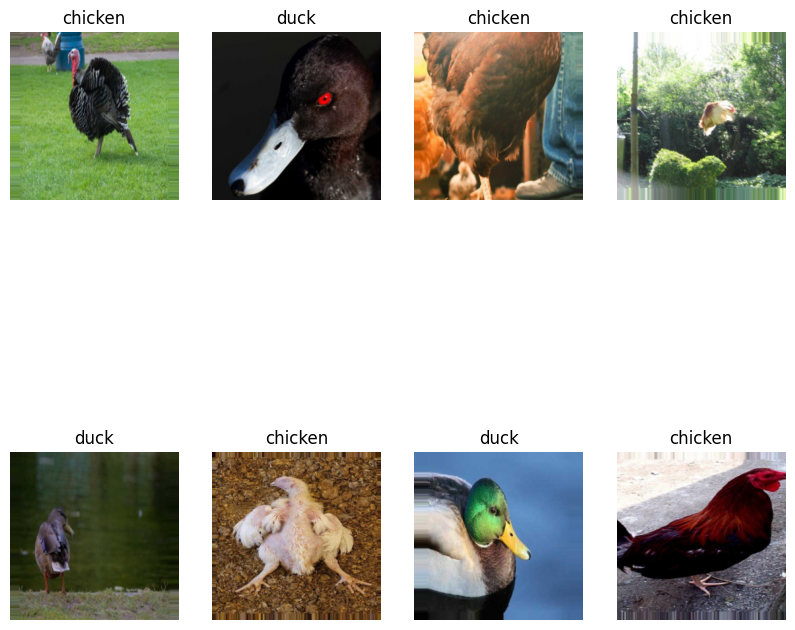

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
batch,p = train_generator.next()
for i in range(1,9):
   plt.subplot(2,4,i)

   image = batch[i]
   plt.imshow(image)

   #The labels are one-hot encoded, so need to find position with value 1
   plt.title(labels[np.argmax(p[i])])
   plt.axis('off')
plt.show()



In [ ]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16,decode_predictions
model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(256,256,3))


In [ ]:
for layers in model.layers:
  layers.trainable=False


#Taking the last layer of the VGG-16 layer
last_output = model.output


#Adding a Flatten layer
vgg_x = Flatten()(last_output)


#Adding a Dense layer for linear output
vgg_x = Dense(128, activation = 'relu')(vgg_x)


#The output layer will give 6 values, a probability distribution for each label
vgg_x = Dense(2, activation = 'softmax')(vgg_x)


#Connecting the linear layers to the VGG-16 model
vgg16_final_model = Model(model.input, vgg_x)


#Compiling the model
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])


In [ ]:
vgg16_final_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [ ]:
vgg16_final_model.fit(train_generator,steps_per_epoch=len(train_generator),epochs=3,validation_data=val_generator,validation_steps=len(val_generator))


Epoch 1/3
21/21 [==============================] - 222s 10s/step - loss: 0.6160 - accuracy: 0.6758 - val_loss: 0.5489 - val_accuracy: 0.7308
Epoch 2/3
21/21 [==============================] - 14s 670ms/step - loss: 0.5045 - accuracy: 0.7829 - val_loss: 0.5311 - val_accuracy: 0.6731
Epoch 3/3
21/21 [==============================] - 14s 681ms/step - loss: 0.4380 - accuracy: 0.8257 - val_loss: 0.4658 - val_accuracy: 0.7404


In [ ]:
vgg16_final_model.save(access_path + "vgg_multi_classifier.h5")


In [ ]:
from keras.models import load_model
vgg_m=load_model(access_path + 'vgg_multi_classifier.h5')

In [ ]:
folders = os.listdir(access_path + "test")
print(folders)


['animal chicken', 'animal duck']


{'image': [], 'label': []}

In [ ]:
pred = test
test=dict()
test["image"]=[]
test["label"]=[]
for l in folders:
  for name in os.listdir(os.path.join(pred,l)):
    test["image"].append(name)
    test["label"].append(l.split()[1])

In [ ]:
import pandas as pd
test_data=pd.DataFrame(test)
test_data.head()

,image,label
0,1ZLB7IELNMCD.jpg,chicken
1,LBB4KFKL4ZE4.jpg,chicken
2,37ROYA9ANCBW.jpg,chicken
3,ICQVKB6KGCPZ.jpg,chicken
4,I05XN1EPRZS2.jpg,chicken


In [ ]:
from keras.preprocessing import image
for i in range(len(test_data)):
  image=os.path.join(pred,"animal " + test_data.loc[i,"label"],test_data.loc[i,"image"])
  img_pred_1=tf.keras.utils.load_img(image,target_size=(256,256))
  img_pred_1=tf.keras.utils.img_to_array(img_pred_1)
  img_pred_1=np.expand_dims(img_pred_1, axis=0)
  rslt= vgg16_final_model.predict(img_pred_1)
  test_data.loc[i,"pred"]=np.argmax(rslt)

1/1 [==============================] - 0s 25ms/step


In [ ]:
for i in range(len(test_data)):
  if test_data.loc[i,"label"]=="chicken":
    test_data.loc[i,"true"] = 0
  else:
    test_data.loc[i,"true"] = 1

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_data["true"], test_data["pred"], target_names = labels))

              precision    recall  f1-score   support

     chicken       0.78      0.98      0.87       115
        duck       0.98      0.73      0.84       115

    accuracy                           0.86       230
   macro avg       0.88      0.86      0.85       230
weighted avg       0.88      0.86      0.85       230



In [ ]:
import os
print(os.listdir(pred + "/animal chicken"))

['1ZLB7IELNMCD.jpg', 'LBB4KFKL4ZE4.jpg', '37ROYA9ANCBW.jpg', 'ICQVKB6KGCPZ.jpg', 'I05XN1EPRZS2.jpg', '5S2Z8N8RHE3T.jpg', 'ATQPWAMPSGZB.jpg', '1O9LZD4GDLEG.jpg', '8NFNS2WCTW8I.jpg', 'DOKYAK4NY2B4.jpg', '9RTWTQTFJC30.jpg', '9Z87EOQOGKDL.jpg', '8QO575X3XQZ6.jpg', 'PPS83G2DYRE0.jpg', 'PD9CHRW0GT3Z.jpg', 'D3YP6N42HIR5.jpg', 'LWYE7NTDECQT.jpg', 'IUMT1HEANNK9.jpg', 'LY5EK3RW4KGP.jpg', '0YRRH5UO983S.jpg', 'N9QYK7SEJI74.jpg', 'OHIFDA3EP9JI.jpg', '6Q16NMCZX1GA.jpg', 'NHT46ANH04FF.jpg', 'FSW4EAY3ZREE.jpg', 'OXZZ7KMKO69Z.jpg', '8UQYKTHY3TCT.jpg', '3PAKQG6U95KF.jpg', 'DXSL1Q28GDAX.jpg', '0U5DJ4AHL7U8.jpg', 'APOL8SJH13QJ.jpg', 'LHNVT9D0QERR.jpg', 'EAMHXE47MXDO.jpg', 'AEN3IABUUT1Q.jpg', 'J674Z0AUDQZC.jpg', '58O558O7Z1EE.jpg', '8GWUIDKYZ1JE.jpg', '5QGOZ68RTPD5.jpg', '8GEPH9CVGADY.jpg', '2MD30734HGEK.jpg', 'DA8RB6X9R74A.jpg', 'JSF3D8YBFXMC.jpg', '7BO7XC21FY83.jpg', 'OA9EKX7B9FHN.jpg', '87MJQ21RUJO3.jpg', '2IH2F7SXSTFS.jpg', '1OX6JD87ZL6M.jpg', '8Y5IBBTVY503.jpg', '7G3QX5Q3WP7Q.jpg', '4DN8EXU7DK8L.jpg',

1/1 [==============================] - 0s 25ms/step


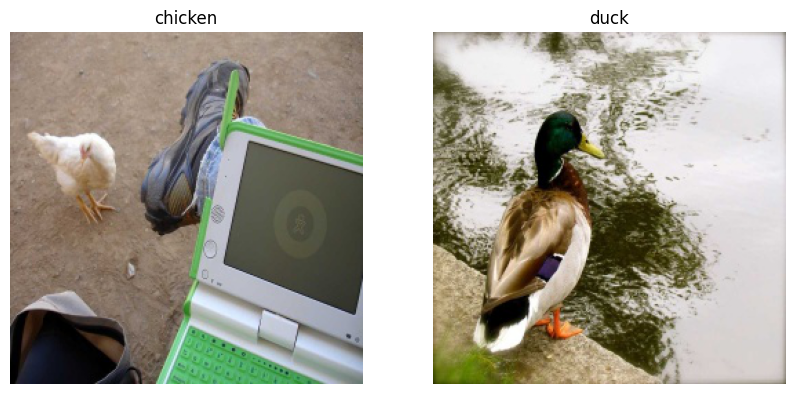

In [ ]:
from keras.preprocessing import image
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

#Loading the image and converting to 256*256 size
img_pred_1=tf.keras.utils.load_img(os.path.join(pred,"animal chicken","ICQVKB6KGCPZ.jpg"),target_size=(256,256))

img_pred_1=tf.keras.utils.img_to_array(img_pred_1)
img_pred_1=np.expand_dims(img_pred_1, axis=0)


#Predicting the label
rslt= vgg16_final_model.predict(img_pred_1)


#Showing the label
l1=labels[np.argmax(rslt)]

ax1.imshow(img_pred_1[0]/255.0)
ax1.set_title(l1)
ax1.axis("off")

img_pred_2=tf.keras.utils.load_img(os.path.join(pred,"animal duck","ESS9THZNSJ3S.jpg"),target_size=(256,256))

img_pred_2=tf.keras.utils.img_to_array(img_pred_2)
img_pred_2=np.expand_dims(img_pred_2, axis=0)


#Predicting the label
rslt= vgg16_final_model.predict(img_pred_2)


#Showing the label
l2=labels[np.argmax(rslt)]

ax2.imshow(img_pred_2[0]/255.0)
ax2.set_title(l2)
ax2.axis("off")

plt.show()



In [ ]:
print('*-' * 170)

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
